# Случайные леса
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать ансамбль деревьев решений, известный как случайный лес, применить его к публичным данным и сравнить его эффективность с ансамблями из самых популярных библиотек.

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
from collections import deque, Counter

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, accuracy_score

### Задание 1 (3 балла)
Реализуем сам Random Forest. Идея очень простая: строим `n` деревьев, а затем берем модальное предсказание. Используйте реализацию дерева из HW3.

#### Параметры конструктора
`n_estimators` - количество используемых для предсказания деревьев.

Остальное - параметры деревьев.

#### Методы
`fit(X, y)` - строит `n_estimators` деревьев по выборке `X`.

`predict(X)` - для каждого элемента выборки `X` возвращает самый частый класс, который предсказывают для него деревья.

In [2]:
def gini(x):
    c = Counter(x)
    #print(c)
    total = len(x)
    ans = 0
    for v in c.values():
        ans += 1.*v/total*(1-1.*v/total)
    return ans
    
def entropy(x):
    c = Counter(x)
    #print(c)
    total = len(x)
    ans = 0
    for v in c.values():
        ans -= 1.*v/total*(math.log2(1.*v/total))
    return ans

def gain(left_y, right_y, criterion):
    joined = np.concatenate((left_y, right_y))
    return (len(joined) * criterion(joined) - len(left_y) * criterion(left_y) - len(right_y) * criterion(right_y))*1./len(joined)


class DecisionTreeNode:
    def __init__(self, depth):
        self.split_dim = None
        self.split_value = None
        self.left = None
        self.right = None
        self.depth = depth
        
        self.leaf = False
        self.elems = None
        self.y = None
        


def get_class(x):
    p = Counter(x)
    return max(p.keys(), key=lambda k: p[k])

def get_probs(x):
    p = Counter(x)
    return {k : v*1./sum(p.values()) for k,v in p.items()}

class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1):
        self.root = None
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
    
    def fit(self, X, y):
        root = DecisionTreeNode(0)
        self.root = root
        elems = range(len(y))
        q = deque()
        q.append((root, elems))
        while (q):
            node, elems = q.popleft()
            if node.depth == self.max_depth:
                node.leaf = True
                node.elems = y[elems]
                node.y = get_class(y[elems])
                continue
            
            # iterate over features
            cur_split_dim = -1
            cur_split_value = -1
            cur_gain = 0
            cur_left = []
            cur_right = []
            for i in range(X.shape[1]):
                vals = X[:, i]
                minn = min(vals)
                maxx = max(vals)
                for b in np.random.uniform(minn, maxx, 20):
                    elem_left = []
                    elem_right = []
                    for e in elems:
                        if X[e, i] < b:
                            elem_left.append(e)
                        else:
                            elem_right.append(e)
                    #print(y)
                    #print(elem_left)
                    tmp_gain = gain(y[elem_left], y[elem_right], gini if self.criterion=='gini' else entropy)
                    if tmp_gain > cur_gain:
                        cur_gain = tmp_gain
                        cur_split_dim = i
                        cur_split_value = b
                        cur_left = elem_left.copy()
                        cur_right = elem_right.copy()
                        
            if len(cur_left) < self.min_samples_leaf or len(cur_right) < self.min_samples_leaf: #cur_gain < 0.01 or 
                node.leaf = True
                node.elems = y[elems]
                node.y = get_class(y[elems])
            else:
                left_node = DecisionTreeNode(node.depth+1)
                right_node = DecisionTreeNode(node.depth+1)
                q.append((left_node, cur_left))
                q.append((right_node, cur_right))
                node.split_dim = cur_split_dim
                node.split_value = cur_split_value
                node.left = left_node
                node.right = right_node
        
                
    def predict_proba(self, X):
        ans = []
        for i in range(X.shape[0]):
            node = self.root
            while not node.leaf:
                if X[i, node.split_dim] < node.split_value:
                    node = node.left
                else:
                    node = node.right
            ans.append(get_probs(node.elems))
        return ans
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

In [3]:
class RandomForestClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1, max_features="auto", n_estimators=10):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.n_estimators = n_estimators

    
    def fit(self, X, y):
        self.estimators = [DecisionTreeClassifier(criterion=self.criterion, max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf) for _ in range(self.n_estimators)]
        for e in self.estimators:
            e.fit(X, y)
        #print(self.estimators)
    
    def predict(self, X):
        preds = np.array([e.predict(X) for e in self.estimators]).T
        ans = []
        for i in range(X.shape[0]):
            c = Counter(preds[i])
            ans.append(max(c.keys(), key=(lambda k: c[k])))
        #print(ans)
        return ans
    
    def predict_proba(self, X):
        preds = np.array([e.predict(X) for e in self.estimators]).T
        ans = []
        for i in range(X.shape[0]):
            c = Counter(preds[i])
            ans.append(c[1]*1./self.n_estimators)
        #print(ans)
        return ans

### Задание 3 (2 балла)
Оптимизируйте по `AUC` на кроссвалидации (размер валидационной выборки - 20%) параметры своей реализации `Random Forest`: 

максимальную глубину деревьев из [2, 3, 5, 7, 10], количество деревьев из [5, 10, 20, 30, 50, 100]. 

Постройте `ROC` кривую (и выведите `AUC` и `accuracy`) для лучшего варианта.

Подсказка: можно построить сразу 100 деревьев глубины 10, а потом убирать деревья и
глубину.

In [4]:
CANCER_DATA_PATH = "cancer.csv"
SPAM_DATA_PATH = "spam.csv"
def read_cancer_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    df = pd.read_csv(path_to_csv, header=0)
    y = [1 if i == 'M' else 0 for i in df["label"]]
    return df.drop("label", axis=1).to_numpy(), np.array(y)

def read_spam_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    df = pd.read_csv(path_to_csv, header=0)
    y = df["label"]
    return df.drop("label", axis=1).to_numpy(), np.array(y.values)

X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
X_spam, y_spam = read_spam_dataset(SPAM_DATA_PATH)

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, train_size = 0.8)
#print(X_test)

In [27]:
# YOUR_CODE
depth = -1
count = -1
AUC = -1
for d in [2, 3, 5, 7, 10]:
    for n in [5, 10, 20, 30, 50, 100]:
        RF = RandomForestClassifier(max_depth=d, n_estimators=n)
        RF.fit(X_train, y_train)
        y_prob = RF.predict_proba(X_test)
        tmp = roc_auc_score(y_test, y_prob)
        print(d, n, tmp)
        if tmp > AUC:
            AUC = tmp
            depth = d
            count = n
            
print(f'AUC={AUC}; max_depth={depth}, n_estimators={count}')

2 5 0.9593521752937441
2 10 0.9663385201651318
2 20 0.9849158463004128
2 30 0.9842807240393776
2 50 0.9874563353445538
2 100 0.9853921879961893
3 5 0.9585582724674501
3 10 0.9695141314703081
3 20 0.9896792632581772
3 30 0.987297554779295
3 50 0.9871387742140363
3 100 0.9909495077802477
5 5 0.9876151159098127
5 10 0.9941251190854239
5 20 0.9899968243886949
5 30 0.9907907272149888
5 50 0.9896792632581772
5 100 0.992378532867577
7 5 0.9817402349952364
7 10 0.9920609717370594
7 20 0.9893617021276595
7 30 0.9912670689107654
7 50 0.9892029215624009
7 100 0.9915846300412829
10 5 0.968720228644014
10 10 0.9871387742140362
10 20 0.9884090187361068
10 30 0.9858685296919658
10 50 0.9925373134328358
10 100 0.9907907272149888
AUC=0.9941251190854239; max_depth=5, n_estimators=10


2 5 0.9593521752937441
2 10 0.9663385201651318
2 20 0.9849158463004128
2 30 0.9842807240393776
2 50 0.9874563353445538
2 100 0.9853921879961893
3 5 0.9585582724674501
3 10 0.9695141314703081
3 20 0.9896792632581772
3 30 0.987297554779295
3 50 0.9871387742140363
3 100 0.9909495077802477
5 5 0.9876151159098127
5 10 0.9941251190854239
5 20 0.9899968243886949
5 30 0.9907907272149888
5 50 0.9896792632581772
5 100 0.992378532867577
7 5 0.9817402349952364
7 10 0.9920609717370594
7 20 0.9893617021276595
7 30 0.9912670689107654
7 50 0.9892029215624009
7 100 0.9915846300412829
10 5 0.968720228644014
10 10 0.9871387742140362
10 20 0.9884090187361068
10 30 0.9858685296919658
10 50 0.9925373134328358
10 100 0.9907907272149888
AUC=0.9941251190854239; max_depth=5, n_estimators=10

In [28]:
def plot_roc_curve(y_test, y_prob):
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([-0.01, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.show()

===== RF =====
AUC=0.9923785328675769; accuracy=0.9473684210526315


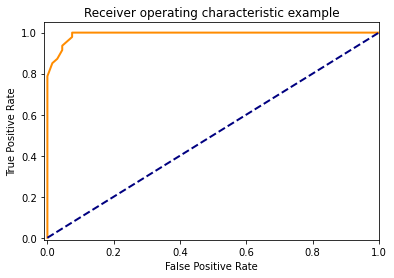

In [47]:
depth = 5
n_est = 10
RF = RandomForestClassifier(max_depth=depth, n_estimators=n_est)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
y_prob = RF.predict_proba(X_test)

print("===== RF =====")
print(f'AUC={roc_auc_score(y_test, y_prob)}; accuracy={accuracy_score(y_test, y_pred)}')

plot_roc_curve(y_test, y_prob)

### Задание 4 (3 балла)
Часто хочется понимать, насколько большую роль играет тот или иной признак для предсказания класса объекта. Есть различные способы посчитать его важность. Один из простых способов сделать это для Random Forest выглядит так:
1. Посчитать out-of-bag ошибку предсказания `err_oob` (https://en.wikipedia.org/wiki/Out-of-bag_error)
2. Перемешать значения признака `j` у объектов выборки (у каждого из объектов изменится значение признака `j` на какой-то другой)
3. Посчитать out-of-bag ошибку (`err_oob_j`) еще раз.
4. Оценкой важности признака `j` для одного дерева будет разность `err_oob_j - err_oob`, важность для всего леса считается как среднее значение важности по деревьям.

Реализуйте функцию `feature_importance`, которая принимает на вход Random Forest и возвращает массив, в котором содержится важность для каждого признака.

In [44]:
def feature_importance(rfc, test):
    X, y = test
    err_oob = accuracy_score(y, rfc.predict(X))
    ans = []
    for i in range(X.shape[1]):
        shuf = list(range(X.shape[0]))
        random.shuffle(shuf)
        tmp = X.copy()
        tmp[:, i] = X[shuf, i]
        err_oob_i = accuracy_score(y, rfc.predict(tmp))
        ans.append(err_oob - err_oob_i)
    return ans

def most_important_features(importance, names, k=20):
    # Выводит названия k самых важных признаков
    idicies = np.argsort(importance)[::-1][:k]
    return np.array(names)[idicies]

Протестируйте решение на простом синтетическом наборе данных. В результате должна получиться точность `1.0`, наибольшее значение важности должно быть у признака с индексом `4`, признаки с индексами `2` и `3`  должны быть одинаково важны, а остальные признаки - не важны совсем.

In [45]:
def synthetic_dataset(size):
    X = [(np.random.randint(0, 2), np.random.randint(0, 2), i % 6 == 3, 
          i % 6 == 0, i % 3 == 2, np.random.randint(0, 2)) for i in range(size)]
    y = [i % 3 for i in range(size)]
    return np.array(X), np.array(y)

X, y = synthetic_dataset(1000)
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X, y)
print("Accuracy:", np.mean(rfc.predict(X) == y))
print("Importance:", feature_importance(rfc, synthetic_dataset(100)))

Accuracy: 1.0
Importance: [0.0, 0.0, 0.18000000000000005, 0.19999999999999996, 0.42000000000000004, 0.0]


Проверьте, какие признаки важны для датасетов cancer и spam?

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, train_size = 0.8)
depth = 5
n_est = 10
RF = RandomForestClassifier(max_depth=depth, n_estimators=n_est)
RF.fit(X_train, y_train)
print("Accuracy:", np.mean(RF.predict(X_test) == y_test))
imp = feature_importance(RF, (X_test, y_test))
print("Importance:", imp)
print("Most important features:", most_important_features(imp, [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30], 5))

Accuracy: 0.9736842105263158
Importance: [0.0, 0.00877192982456143, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00877192982456143, 0.0, 0.0, 0.0, 0.00877192982456143, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.026315789473684292, 0.07894736842105265, 0.01754385964912286, 0.00877192982456143, 0.0, 0.0, 0.03508771929824561, 0.0, 0.0]
Most important features: [23 28 22 24  2]


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_spam, y_spam, train_size = 0.8)
depth = 5
n_est = 10
RF = RandomForestClassifier(max_depth=depth, n_estimators=n_est)
RF.fit(X_train, y_train)
print("Accuracy:", np.mean(RF.predict(X_test) == y_test))
imp = feature_importance(RF, (X_test, y_test))
print("Importance:", imp)
print("Most important features:", most_important_features(imp, ['word_freq_make','word_freq_address','word_freq_all','word_freq_3d','word_freq_our','word_freq_over','word_freq_remove','word_freq_internet','word_freq_order','word_freq_mail','word_freq_receive','word_freq_will','word_freq_people','word_freq_report','word_freq_addresses','word_freq_free','word_freq_business','word_freq_email','word_freq_you','word_freq_credit','word_freq_your','word_freq_font','word_freq_000','word_freq_money','word_freq_hp','word_freq_hpl','word_freq_george','word_freq_650','word_freq_lab','word_freq_labs','word_freq_telnet','word_freq_857','word_freq_data','word_freq_415','word_freq_85','word_freq_technology','word_freq_1999','word_freq_parts','word_freq_pm','word_freq_direct','word_freq_cs','word_freq_meeting','word_freq_original','word_freq_project','word_freq_re','word_freq_edu','word_freq_table','word_freq_conference','char_freq_:','char_freq_(','char_freq_[','char_freq_!','char_freq_$','char_freq_#','capital_run_length_average','capital_run_length_longest','capital_run_length_total'], 5))

Accuracy: 0.9022801302931596
Importance: [0.0, 0.0, 0.0, 0.0, 0.004343105320304019, 0.0, 0.057546145494028145, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.013029315960912058, -0.0010857763300760048, 0.0010857763300760048, 0.0010857763300760048, 0.0, 0.0, 0.0, 0.011943539630836053, 0.0, 0.04017372421281207, 0.0010857763300760048, 0.004343105320304019, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0032573289902280145, 0.0, 0.0, 0.0, 0.0, 0.0032573289902280145, 0.0, 0.0, 0.0, 0.008686210640608039, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03583061889250805, 0.055374592833876135, 0.0, 0.0010857763300760048, 0.0021715526601520097, 0.0]
Most important features: ['word_freq_remove' 'char_freq_$' 'word_freq_hp' 'char_freq_!'
 'word_freq_free']


_Ваш ответ_

Для набора данных cancer наиболее важны признаки 23 28 22 24 2

Для набора данных spam наиболее важны признаки 'word_freq_remove', 'char_freq_$', 'word_freq_hp', 'char_freq_!', 'word_freq_free'

### Задание 5 (2 балла)
В качестве альтернативы попробуем библиотечные реализации ансамблей моделей. 

1. [CatBoost](https://catboost.ai/docs/)
2. [XGBoost](https://xgboost.readthedocs.io/en/latest/)
3. [LightGBM](https://lightgbm.readthedocs.io/en/latest/)


Установите необходимые библиотеки. 
Возможно, потребуется установка дополнительных пакетов

In [12]:
!pip install lightgbm
!pip install catboost
!pip install xgboost

     |████████████████████████████████| 65.7MB 57kB/s 


Также, как и реализованный нами RandomForest, примените модели для наших датасетов.

Для стандартного набора параметров у каждой модели нарисуйте `ROC` кривую и выведите `AUC` и `accuracy`.

Посчитайте время обучения каждой модели (можно использовать [timeit magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit)). 

Сравните метрики качества и скорость обучения моделей. Какие выводы можно сделать?

In [13]:
# YOUR_CODE
X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, train_size = 0.8)

10 loops, best of 5: 118 ms per loop
===== lightgbm =====
AUC=0.9942838996506828; accuracy=0.956140350877193


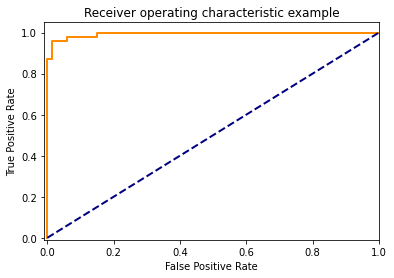

In [20]:
from lightgbm import LGBMClassifier

model = LGBMClassifier()
%timeit model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

print("===== lightgbm =====")
print(f'AUC={roc_auc_score(y_test, y_prob[:, 1])}; accuracy={accuracy_score(y_test, y_pred)}')
plot_roc_curve(y_test, y_prob[:, 1])

10 loops, best of 5: 89.2 ms per loop
===== xgboost =====
AUC=0.9930136551286122; accuracy=0.9473684210526315


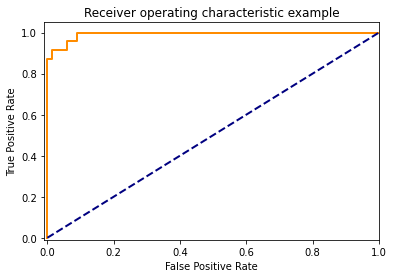

In [23]:
from xgboost import XGBClassifier

model = XGBClassifier()
%timeit model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

print("===== xgboost =====")
print(f'AUC={roc_auc_score(y_test, y_prob[:, 1])}; accuracy={accuracy_score(y_test, y_pred)}')
plot_roc_curve(y_test, y_prob[:, 1])

1 loop, best of 5: 8.78 s per loop
===== catboost =====
AUC=0.9952365830422356; accuracy=0.9473684210526315


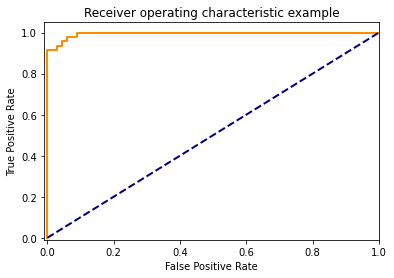

In [26]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(verbose=False)
%timeit model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

print("===== catboost =====")
print(f'AUC={roc_auc_score(y_test, y_prob[:, 1])}; accuracy={accuracy_score(y_test, y_pred)}')
plot_roc_curve(y_test, y_prob[:, 1])

_Ваш ответ_

Все модели показывают очень высокое качество классификации. CatBoost чуть лучше по качеству, но заметно проигрывает по скорости обучения. XGBoost самый быстрый. Все модели показывают качество очень близкое к RandomForest. Возможно это связано с тем, что датасет и задача не очень сложные и даже случайный лес хорошо ее решает.